[![1.png](https://i.postimg.cc/GmRCBZ1P/1.png)](https://postimg.cc/2V0JM9y3)

<div style="padding:20px 20px 20px; 
            color:#004346;
            font-size:40px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 
<p style="font-weight: bold; text-align: center;">Прогнозирование заказов такси</p>

</div>

<div style="padding:0px 40px 30px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:450;"> 
    
    
__Постановка задачи:__ предсказать количество заказов на следующий час в каждом округе Чикаго
    
__Оценка результата:__ Сравнение качества работы моделей. Значение метрики MAE
    
__Описание данных:__ Исторические данные о поездках такси в Чикаго за [2022](https://data.cityofchicago.org/Transportation/Taxi-Trips-2022/npd7-ywjz) и [2023](https://data.cityofchicago.org/Transportation/Taxi-Trips-2023/e55j-2ewb) годы.

</div>    

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Используемые библиотеки

</div>

In [6]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from datetime import timedelta, datetime

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split


from sklearn.model_selection import TimeSeriesSplit, cross_val_predict
from sklearn.metrics import mean_absolute_error

import optuna

from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Ridge

import lightgbm as lgb

from catboost import CatBoostRegressor, Pool

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder

from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator 
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# константы
RANDOM_SEED = 42

In [7]:
# запуск spark-сессии
SPARK_MASTER_IP = '172.18.0.2' 
spark = SparkSession.builder.appName("pyspark-taxi-forecasting")\
.master(f"spark://{SPARK_MASTER_IP}:7077")\
.config("spark.executor.cores", 1)\
.config("spark.task.cpus", 1)\
.getOrCreate()

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Загрузка данных

</div>

In [8]:
# загрузка данных
try:
    df_22 = spark.read.csv('data/Taxi_Trips_-_2022.csv', header=True, inferSchema=True)
    df_23 = spark.read.csv('data/Taxi_Trips_-_2023.csv', header=True, inferSchema=True)
    print('Данные загружены корректно')
except:
    print('Данные не доступны')
    raise SystemExit(0)

Данные загружены корректно


<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:13px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Предобработка данных

</div>

__Сравнение признаков:__

In [4]:
# получение признаков из df_22 и df_23
columns_df_22 = df_22.columns
columns_df_23 = df_23.columns

# сравнение признаков
common_columns = set(columns_df_22) & set(columns_df_23)
unique_columns_df_22 = set(columns_df_22) - common_columns
unique_columns_df_23 = set(columns_df_23) - common_columns

# вывод результатов
print(f'Общие признаки: {common_columns}')
print(f'Признаки уникальные для df_22: {unique_columns_df_22}')
print(f'Признаки уникальные для df_23: {unique_columns_df_23}')

Общие признаки: {'Trip End Timestamp', 'Pickup Centroid Longitude', 'Dropoff Centroid  Location', 'Pickup Centroid Location', 'Trip Start Timestamp', 'Dropoff Community Area', 'Pickup Community Area', 'Trip Miles', 'Trip Seconds', 'Tolls', 'Trip ID', 'Pickup Census Tract', 'Extras', 'Trip Total', 'Tips', 'Dropoff Census Tract', 'Payment Type', 'Pickup Centroid Latitude', 'Fare', 'Taxi ID', 'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude', 'Company'}
Признаки уникальные для df_22: set()
Признаки уникальные для df_23: set()


- Результаты сравнения признаков говорят о том, что оба набора данных (df_22 и df_23) имеют одинаковые признаки, и в них нет уникальных признаков для каждого года. Это  облегчает задачу объединения данных и анализа в рамках проекта.

Из всех признаков нам необходимы:
- `Trip Start Timestamp`: Время начала поездки, округленное до ближайших 15 минут.
- `Pickup Community Area`: Общественная территория, с которой началась поездка. Этот признак указывает на округ (community area), в котором началась поездка.(пропуски обозначаюз поездки за пределами города)

__Проверка данных на наличие дубликатов__

In [5]:
def duplicates(df):
    duplicates = df.groupBy(df.columns).count().filter(F.col('count') > 1)
    if duplicates.count() > 0:
        print('Обнаружены дубликаты:')
        duplicates.show()
    else: print('Дубликаты отсутствуют')

In [6]:
# проверка данных за 2022г.
duplicates(df_22)

Дубликаты отсутствуют


In [7]:
# проверка данных за 2023г.
duplicates(df_23)

Дубликаты отсутствуют


__Объединение датасетов__

In [8]:
# исходный размер датасетов
print(f'Количество строк в df_22: {df_22.count()}')
print(f'Количество строк в df_23: {df_23.count()}')

Количество строк в df_22: 6382425
Количество строк в df_23: 3783730


In [9]:
# выбор признаков `Trip Start Timestamp` и `Pickup Community Area` из df_22
df_22_selected = df_22.select('Trip Start Timestamp', 'Pickup Community Area')

# выбор признаков `Trip Start Timestamp` и `Pickup Community Area` из df_23
df_23_selected = df_23.select('Trip Start Timestamp', 'Pickup Community Area')

# объединение данных df_22 и df_23
df = df_22_selected.union(df_23_selected)

In [5]:
# проверка корректности объединения данных
if df.count() == df_22.count() + df_23.count():
    print('Данные объеденены корректно')
else: print('Данные объеденены некорректно')

Данные объеденены корректно


__Обработка пропусков__

Пропуски в текущих данных означают поездки за городом

In [10]:
# удаление записей с пропусками из датафрейма
df_cleaned = df.na.drop(how='any')

# количество строк до и после удаления пропусков
print(f'Количество строк до удаления пропусков: {df.count()}')
print(f'Количество строк после удаления пропусков: {df_cleaned.count()}')

Количество строк до удаления пропусков: 10166155
Количество строк после удаления пропусков: 9484535


__Типы данных__

In [13]:
# схема данных для датафрейма df_cleaned
df_cleaned.printSchema()

root
 |-- Trip Start Timestamp: string (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)



In [11]:
# преобразование рпизнака `Trip Start Timestamp` в тип данных timestamp
df = df_cleaned.withColumn('Trip Start Timestamp', F.to_timestamp(
    F.col('Trip Start Timestamp'), 'MM/dd/yyyy hh:mm:ss a'))

In [12]:
# округление времени до ближайшего часа
df = df.withColumn('Trip Start Timestamp', F.date_trunc('hour', 'Trip Start Timestamp'))

In [13]:
# агрегация данных и подсчет количества одинаковых строк
agg_df = df.groupBy('Trip Start Timestamp', 'Pickup Community Area')\
               .agg(F.count('*').alias('count'))

# переименование столбцов
agg_df = agg_df.withColumnRenamed('Trip Start Timestamp', 'time')\
                    .withColumnRenamed('Pickup Community Area', 'area')

# просмотр первых 5-ти записей в агрегированном датафрейме
agg_df.show(5)

+-------------------+----+-----+
|               time|area|count|
+-------------------+----+-----+
|2022-03-21 10:00:00|  73|    1|
|2022-03-21 16:00:00|  19|    3|
|2022-03-21 16:00:00|  15|    5|
|2022-03-21 17:00:00|  38|    4|
|2022-03-21 20:00:00|  71|    2|
+-------------------+----+-----+
only showing top 5 rows



In [19]:
# подсчет количества уникальных значений в столбце `area`
unique_areas_count = agg_df.select('area').distinct().count()
print(f'Количество уникальных значений в столбце `area`: {unique_areas_count}')

Количество уникальных значений в столбце `area`: 77


- У нас представленны данные по 77 [округам](https://en.wikipedia.org/wiki/Community_areas_in_Chicago), что соответствует реальному количеству округов в Чикаго.

__Проверим хронологический порядок данных:__

In [20]:
def num_out_of_order_areas(df):
    # оконная функция для сортировки данных по времени внутри каждого округа
    window_spec = Window.partitionBy('area').orderBy('time')
    # сортировка данных
    sorted_df = agg_df.withColumn('sorted', F.row_number().over(window_spec))
    # проверка хронологии данных для каждого округа
    sorted_df = sorted_df.filter(F.col('sorted') > 1)
    # подсчет количества округов, где хронология нарушена
    sorted_df = sorted_df.select('area').distinct()
    count = sorted_df.count()
    sorted_df = None
    return count

In [21]:
print(f'Количество округов, где хронология нарушена: {num_out_of_order_areas(agg_df)}')

Количество округов, где хронология нарушена: 77


- В каждом округе, за время наблюдения, случалиси часы в которые небыло заказов такси, необходимо восстановить эти данные. отобразив нулевое количество заказов

In [14]:
# поиск минимального и максимального значения времени в agg_df
min_time = agg_df.select(F.min('time')).first()[0]
max_time = agg_df.select(F.max('time')).first()[0]

# создание временного ряда
time_range = [(min_time + timedelta(hours=i)) for i in range(int((max_time - min_time).total_seconds() / 3600) + 1)]

# создание DataFrame с временным рядом
time_series_df = spark.createDataFrame([(t,) for t in time_range], ['time'])

# создание DataFrame с уникальными округами
unique_areas_df = agg_df.select('area').distinct()

# добавление столбца time к каждому округу
full_data = unique_areas_df.crossJoin(time_series_df)

# присоединение агрегированных данных к полному временному ряду
result_df = full_data.join(agg_df, ['time', 'area'], 'left').fillna(0, subset=['count'])

# вывод результат
result_df.show(5)

+-------------------+----+-----+
|               time|area|count|
+-------------------+----+-----+
|2022-01-01 00:00:00|  65|    0|
|2022-01-01 00:00:00|  76|   24|
|2022-05-09 00:00:00|  31|    0|
|2022-05-09 00:00:00|  34|    2|
|2022-05-09 00:00:00|  65|    0|
+-------------------+----+-----+
only showing top 5 rows



Проверим корректность восстановления хронологических данных:
  - Сумма заказов исходных данных должна совпадать с суммой заказов в данных с восстановленным хронологическим порядком.

In [23]:
if result_df.agg(F.sum('count')).collect()[0][0] == agg_df.agg(F.sum('count')).collect()[0][0]:
    print('Хронологический порядок данных востановлен корректно')
else: print('Данные искаженны')

Хронологический порядок данных востановлен корректно


<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:13px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Анализ данных

</div>

__Общая информация__

In [24]:
result_df.describe('count').show()

+-------+-----------------+
|summary|            count|
+-------+-----------------+
|  count|          1066373|
|   mean|8.894200247005504|
| stddev|35.12365798973102|
|    min|                0|
|    max|              591|
+-------+-----------------+



- Общий анализ сводки говорит о том, что есть значительная изменчивость количества заказов такси по часам и округам в Чикаго, а также некоторые пики активности, которые могут быть связаны с определенными событиями или периодами.

__Зависимость среднего количества заказов в час от округа__

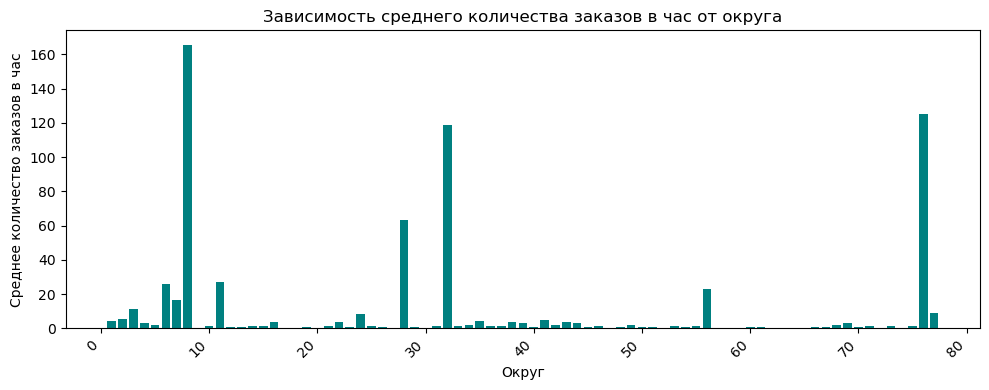

In [25]:
# группировка данных по округам и рассчет среднее количество заказов
avg_orders_by_area = result_df.groupBy('area').agg(F.mean('count').alias('avg_count'))

# получение данных для построения графика
areas = avg_orders_by_area.select('area').rdd.flatMap(lambda x: x).collect()
avg_counts = avg_orders_by_area.select('avg_count').rdd.flatMap(lambda x: x).collect()

# построение графика
plt.figure(figsize=(10, 4))
plt.bar(areas, avg_counts, color='teal')
plt.xlabel('Округ')
plt.ylabel('Среднее количество заказов в час')
plt.title('Зависимость среднего количества заказов в час от округа')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- Наблюдается большой разброс среднего количества заказов в час между округами, что может указывать на неравномерное использование такси в разных часах и в разных частях города.
- График позволяет выделить округа с высокой и низкой активностью заказов, что может быть полезной информацией для планирования ресурсов и управления такси в разных частях города.

__Зависимость среднего количества заказов такси от часа__

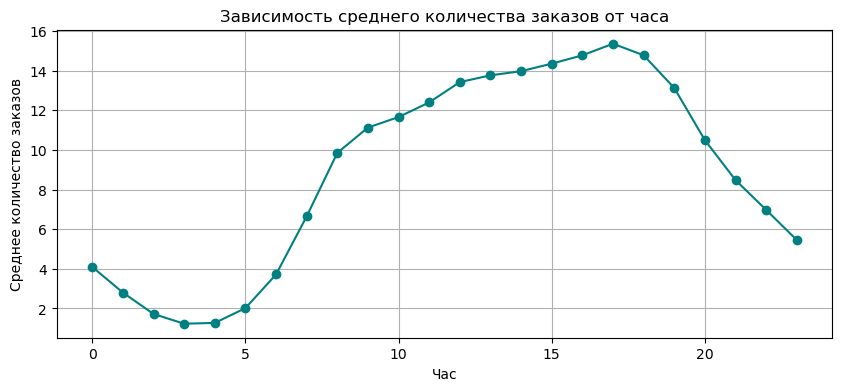

In [26]:
# рассчет признака с часом
result_df_with_hour = result_df.withColumn('hour', F.hour('time'))

# рассчет среднего количество заказов по часам
avg_counts_by_hour = result_df_with_hour.groupBy('hour').agg(F.avg('count').alias('avg_count')).orderBy('hour')
avg_counts_by_hour_pd = avg_counts_by_hour.toPandas()

# построение графика
plt.figure(figsize=(10, 4))
plt.plot(avg_counts_by_hour_pd['hour'], avg_counts_by_hour_pd['avg_count'], marker='o', color='teal')
plt.title('Зависимость среднего количества заказов от часа')
plt.xlabel('Час')
plt.ylabel('Среднее количество заказов')
plt.grid(True)
plt.show()

- Из графика и данных видно, что среднее количество заказов такси в Чикаго имеет характерный пик в период с 16 до 18 часов, что, вероятно, связано с концом рабочего дня и повышенным спросом на транспорт. Также интересно, что в период ночных часов (с 0 до 5 часов) количество заказов снижается, что может быть обусловлено менее активной деятельностью и пониженным спросом на такси в эти часы.

__Зависимость среднего количества заказов такси от дня недели__

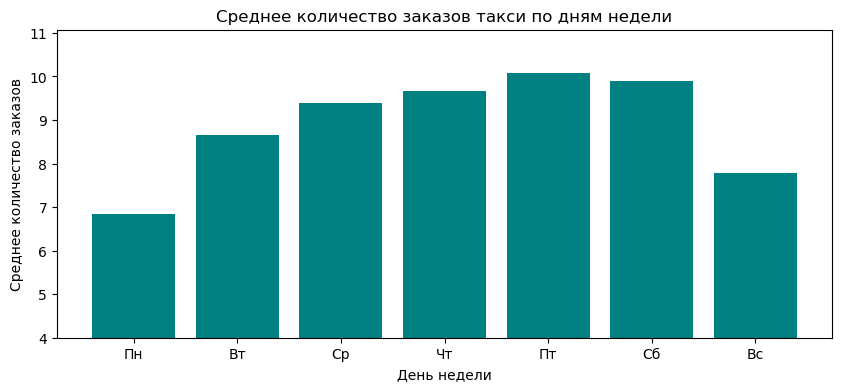

In [27]:
# рассчет среднего количества заказов такси по дням недели
avg_counts_by_weekday = result_df.groupBy(F.dayofweek('time').alias('weekday')).avg('count').orderBy('weekday')

# подготовка данных
weekdays = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
avg_counts = avg_counts_by_weekday.select('avg(count)').rdd.flatMap(lambda x: x).collect()

# построение графика
plt.figure(figsize=(10, 4))
plt.bar(weekdays, avg_counts, color='teal')
plt.xlabel('День недели')
plt.ylabel('Среднее количество заказов')
plt.title('Среднее количество заказов такси по дням недели')
plt.xticks(rotation=0)
plt.ylim(4, max(avg_counts) + 1)  # установлено начальное значение оси Y на 4
plt.show()

- График отражает зависимость среднего количества заказов такси от дня недели в городе Чикаго. Из него видно, что наибольшее среднее количество заказов приходится на четверг, пятницу и субботу. Это может быть связано с активностью вечерних и ночных мероприятий, а также с возможностью отдохнуть от работы в конце недели. 

__Зависимость среднего количества заказов такси от месяца года__

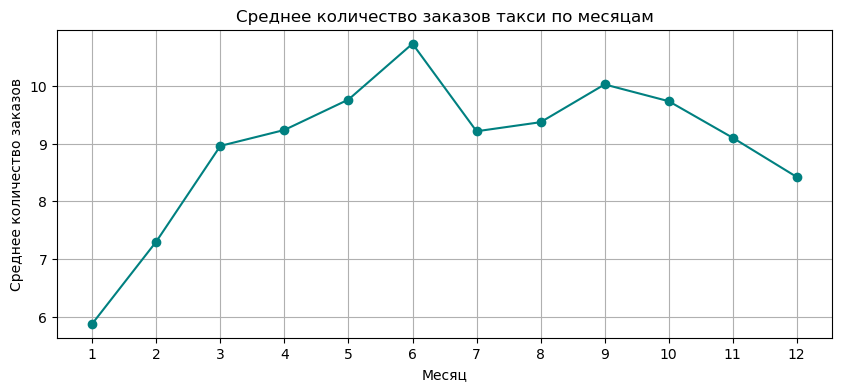

In [28]:
# рассчет среднего количества заказов по месяцам
avg_counts_by_month = result_df.groupBy(F.month('time').alias('month'))\
                               .agg(F.avg('count').alias('avg_count')).orderBy('month')

months = [row.month for row in avg_counts_by_month.select('month').collect()]
avg_counts = [row.avg_count for row in avg_counts_by_month.select('avg_count').collect()]

# построение графика
plt.figure(figsize=(10, 4))
plt.plot(months, avg_counts, marker='o', color='teal')
plt.xlabel('Месяц')
plt.ylabel('Среднее количество заказов')
plt.title('Среднее количество заказов такси по месяцам')
plt.xticks(months)
plt.grid(True)
plt.show()

- Из графика зависимости среднего количества заказов такси от месяца видно, что наибольшее среднее количество заказов приходится на месяцы: июнь и сентябрь. Это может быть связано с тем, что летом и в начале осени люди чаще путешествуют, проводят время на отдыхе и посещают различные мероприятия, что ведет к увеличению спроса на такси. Наименьшее среднее количество заказов наблюдается в декабре, возможно, из-за того, что это время года связано с праздниками и отпусками, когда многие люди остаются дома или уезжают из города.

## Визуализация трендов и сезонности временного ряда
- Посмотрим на тренд и сезонность всего временного ряда
- Визуализируем данные за последний месяц

In [29]:
# агрегация данных по дате
agg_result = result_df.groupBy('time').agg(F.avg('count').alias('avg_count'))
# преобразование Pandas DataFrame для декомпозиции
agg_result = agg_result.select('time', 'avg_count').toPandas()
# установка столбеца `time` как индекс
agg_result.set_index('time', inplace=True)
# сортировка данных
agg_result = agg_result.sort_index(ascending=True)
# вывод данных
display(agg_result.head(2))

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,avg_count
time,
2022-01-01 00:00:00,5.727273
2022-01-01 01:00:00,7.402597


In [30]:
# проверка хронологии данных
if agg_result.index.is_monotonic_increasing:
    print('Данные представлены в хронологическом порядке')
else: print('Хронологический порядок в данных нарушен')

Данные представлены в хронологическом порядке


In [31]:
# декомпозиция
decomposition = seasonal_decompose(agg_result)

__Тренд всего временного ряда__

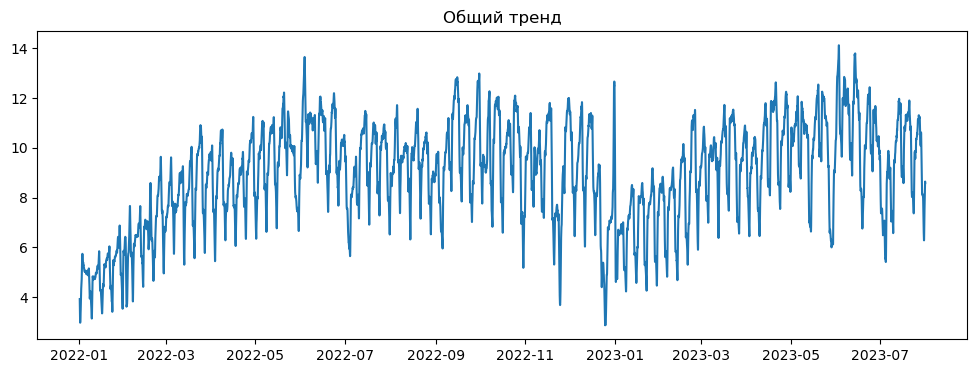

In [32]:
# визуализизвция тренда всего временного ряда
plt.figure(figsize=(12, 4))
plt.plot(decomposition.trend)
plt.title('Общий тренд')
plt.show()

__Тренд, сезонность, остатки временного ряда за последний месяц__

In [33]:
print(f'Данные представленны в промежутке от {agg_result.index.min()} до {agg_result.index.max()}')

Данные представленны в промежутке от 2022-01-01 00:00:00 до 2023-08-01 00:00:00


<function matplotlib.pyplot.show(close=None, block=None)>

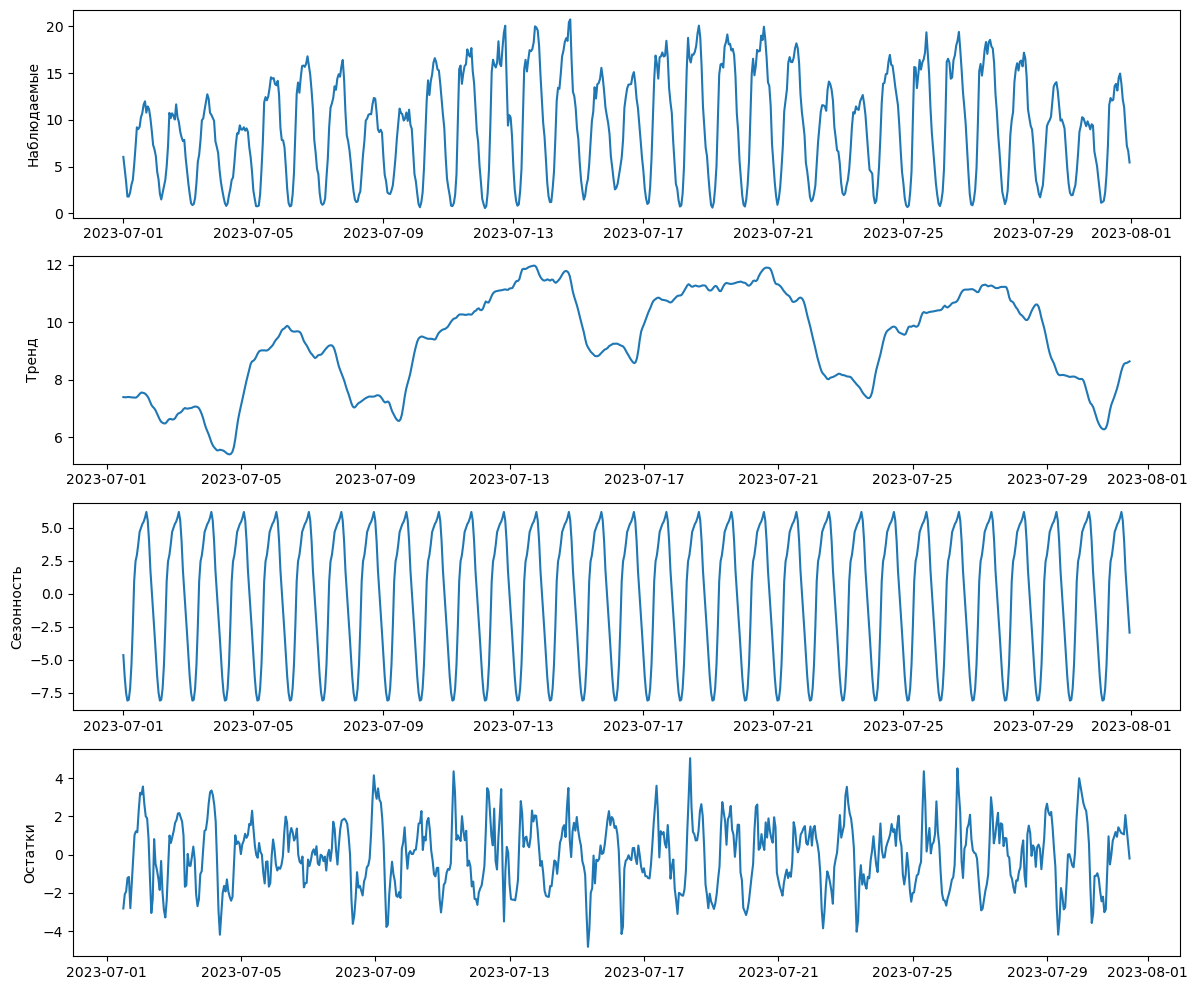

In [34]:
decomposition = seasonal_decompose(agg_result['2023-07':'2023-07'])

plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(agg_result['2023-07':'2023-07'].index, decomposition.observed)
plt.ylabel('Наблюдаемые')

plt.subplot(4, 1, 2)
plt.plot(agg_result['2023-07':'2023-07'].index, decomposition.trend)
plt.ylabel('Тренд')

plt.subplot(4, 1, 3)
plt.plot(agg_result['2023-07':'2023-07'].index, decomposition.seasonal)
plt.ylabel('Сезонность')

plt.subplot(4, 1, 4)
plt.plot(agg_result['2023-07':'2023-07'].index, decomposition.resid)
plt.ylabel('Остатки')

plt.tight_layout()
plt.show

- На общем тренде можно наблюдать сезонность заказов такси.
- Присутствует недельная сезонность.
- Так же следует отметить суточную сезонность, на дневные часы приходся пиковое значение заказов.

__Проверка приводимости временного ряда к стационарному__

In [35]:
ts = agg_result['avg_count']
st_test = adfuller(ts, regression='ctt')
# если значение с индексом 1 меньше P-Value (0.05), то ряд приводим к стационарному
if st_test[1] < 0.05: print('Временной ряд приводим к стационарному')
else: print('Временной ряд не может быть приведен к стационарному')

Временной ряд приводим к стационарному


- Временной ряд приводим к стационарному, как следствие, данные подлежат прогнозированю.

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Подготовка данных к построению модели
    
</div>

- Так как присутствует суточная и недельная и месяцная сезонность из временных признаков нас интересует только значение часа, дня недели и месяца Т.к. данные представлемы за не полные два года, значение года , по причине отсутствия сезонности этих признаков.
- Лаги ограничим 168, сюда войдут основные сезонные значения: суточные и недельные:
    - 24-й лаг, который будет отражать суточную сезонность
    - 168-й лаг, который будет отражать недельную сезонность
- Скользяшее среднее за неделю и месяц
- Среднее значение заказов по округам

__Признаки с часом, днем недели, месяцем и годом__

In [15]:
result_df = result_df.withColumn('hour', F.hour('time')) \
                     .withColumn('dayofweek', F.dayofweek('time')) \
                     .withColumn('month', F.month('time')) \
                     .withColumn('year', F.year('time'))

# обновленный датасет
result_df.show(2)

+-------------------+----+-----+----+---------+-----+----+
|               time|area|count|hour|dayofweek|month|year|
+-------------------+----+-----+----+---------+-----+----+
|2022-01-01 00:00:00|  65|    0|   0|        7|    1|2022|
|2022-05-09 00:00:00|  31|    0|   0|        2|    5|2022|
+-------------------+----+-----+----+---------+-----+----+
only showing top 2 rows



__Лаги__

In [16]:
# задаем количество лагов
max_lag = 168
# окно для разбиения по округам и упорядочивания по времени
window_spec = Window().partitionBy('area').orderBy('time')
# добавляем лаги для каждого округа
for lag in range(1, max_lag + 1):
    lag_col_name = 'lag_{}'.format(lag)
    result_df = result_df.withColumn(lag_col_name, F.lag('count', lag).over(window_spec))

Проверим лаги по количеству пропусков:
- в признаке первого лага должно быть 1 пропуск * 77 округов = 77
- в 168, соответственно: 168*77 = 12936

In [39]:
result_df.select(F.sum(F.col('lag_1').isNull().cast('int'))).show()

+---------------------------------+
|sum(CAST((lag_1 IS NULL) AS INT))|
+---------------------------------+
|                               77|
+---------------------------------+



In [38]:
result_df.select(F.sum(F.col('lag_168').isNull().cast('int'))).show()

+-----------------------------------+
|sum(CAST((lag_168 IS NULL) AS INT))|
+-----------------------------------+
|                              12936|
+-----------------------------------+



- Лаги созданы корректно.

__Скользяшее среднее за неделю и месяц__
- Необходимо учесть, что бы данные не включали текущую дату.

In [17]:
# окно для вычисления скользящего среднего за неделю (7 дней)
week_window = Window.partitionBy('area').orderBy('time').rowsBetween(-192, -24)

# окно для вычисления скользящего среднего за месяц (30 дней)
month_window = Window.partitionBy('area').orderBy('time').rowsBetween(-744, -24)

# вычисление скользящего среднего за неделю и месяц
result_df = result_df.withColumn('avg_week', F.avg('count').over(week_window))
result_df = result_df.withColumn('avg_month', F.avg('count').over(month_window))

__Среднее значение заказов по округам за все время__

In [18]:
# окно для группировки по округам
window_spec = Window.partitionBy('area')

# добавление столбца среднего значения заказов по округам за все время
result_df = result_df.withColumn('avg_count_all_time',F.avg('count').over(window_spec))

In [19]:
# удаляем строк с пропущенными значениями
result_df = result_df.dropna()

## Выделение обучающей и тестовой выборок

In [20]:
# определение временного порога для разделения на трейн и тест 2023-08-01 00:00:00
split_time_valid = datetime(2023, 5, 1, 0, 0) 
split_time_test = datetime(2023, 8, 1, 0, 0)
# разделение на трейн и тест
train_data = result_df.filter(result_df['time'] < split_time_valid)
valid_data = result_df.filter((result_df['time'] >= split_time_valid)&(result_df['time'] < split_time_test))
test_data = result_df.filter(result_df['time'] == split_time_test)
# отображение размеров наборов данных
print(f'Размер train_data: {train_data.count()}')
print(f'Размер valid_data: {valid_data.count()}')
print(f'Размер test_data: {test_data.count()}')

Размер train_data: 883344
Размер valid_data: 170016
Размер test_data: 77


__Подготовка признаков:__
- Создадим пайплайн, который будет применять кодирование One-Hot Encoding (OHE) к категориальным признакам и стандартизацию к числовым признакам. 

In [21]:
# списки категориальных и числовых признаков
categorical_cols = ['hour', 'dayofweek', 'month', 'year', 'area']
numeric_cols = ['lag_{}'.format(i) for i in range(1, 169)] + ['avg_week', 'avg_month', 'avg_count_all_time']

In [22]:
# пайплайн для категориальных признаков
indexers = [StringIndexer(inputCol=col, outputCol=col + '_index', handleInvalid='keep') for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=col + '_index', outputCol=col + '_ohe') for col in categorical_cols]
assembler_cat = VectorAssembler(inputCols=[col + '_ohe' for col in categorical_cols], outputCol='cat_features')

In [23]:
# пайплайн для числовых признаков
assembler_num = VectorAssembler(inputCols=numeric_cols, outputCol='num_features')
scaler = StandardScaler(inputCol='num_features', outputCol='scaled_num_features', withStd=True, withMean=True)

In [24]:
# объединенние результатов пайплайнов
assembler = VectorAssembler(inputCols=['cat_features', 'scaled_num_features'], outputCol='features')
# итоговый пайплайн
pipeline = Pipeline(stages=indexers + encoders + [assembler_cat, assembler_num, scaler, assembler])

In [25]:
# обучение пайплайна
pipeline_model = pipeline.fit(train_data)
# применение пайплайна к трейн и тест данным
train_data_transformed = pipeline_model.transform(train_data)
valid_data_transformed = pipeline_model.transform(valid_data)
test_data_transformed = pipeline_model.transform(test_data)
# сортировка данных по столбцу 'time' по возрастанию
train_data_transformed = train_data_transformed.orderBy(F.asc('time'))
valid_data_transformed = valid_data_transformed.orderBy(F.asc('time'))
test_data_transformed = test_data_transformed.orderBy(F.asc('time'))

__Создание выборок для обучения__

In [26]:
# удаление столбца time
train_data_transformed = train_data_transformed.drop('time')
valid_data_transformed = valid_data_transformed.drop('time')
test_data_transformed = test_data_transformed.drop('time')

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Выбор оптимальной модели
    
</div>

- Возьмем выборку из `train_data_transformed` для выбора модели и подбора гитерпараметров.

In [63]:
# сортировка для сохранения хронологи в данных
sorted_train_data = train_data.orderBy(F.asc('time'))
# выборка для подбора моделей
limited_df = sorted_train_data.drop('time').limit(50000)
# преобразование в объект Pandas DataFrame
pandas_df = limited_df.toPandas()
display(pandas_df.head(2))

,area,count,hour,dayofweek,month,year,lag_1,lag_2,lag_3,lag_4,...,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,avg_week,avg_month,avg_count_all_time
0,5,0,0,7,1,2022,0,0,0,0,...,1,3,4,1,5,7,0,1.448276,1.448276,2.080728
1,1,2,0,7,1,2022,2,1,6,4,...,1,0,4,5,3,2,1,3.917241,3.917241,4.080944


__Выделение признаков для обучения и целевого признака__

In [64]:
X = pandas_df.drop('count', axis=1).values
y = pandas_df['count'].values # целевой признак

In [71]:
# выборки для кроссвалидации временного ряда
tscv = TimeSeriesSplit(n_splits=4)

# функция для расчета RMSE
def mae_score(values, predict):
    return mean_absolute_error(values, predict)

# функция для вывода результатов
def output_results(trial):
    print('Результаты подборы параметров:')
    print('  MAE:', round(trial.value, 2))
    print('  Params: ')
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

## LinearRegression
    
</div>

In [ ]:
def objective_lr(trial):

    # параметры подбора
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    positive = trial.suggest_categorical('positive', [True, False])
    copy_X = trial.suggest_categorical('copy_X', [True, False])
    n_jobs = trial.suggest_int('n_jobs', -1, 16)

    # экземпляр модели
    model = LinearRegression(fit_intercept = fit_intercept,
                             positive = positive,
                             copy_X = copy_X,
                             n_jobs = n_jobs)
    mae_scores = []
    # кроссвалидация
    for train_id, val_id in tscv.split(X):
        X_train_fold, X_val_fold = X[train_id], X[val_id]
        y_train_fold, y_val_fold = y[train_id], y[val_id]
        
        model.fit(X_train_fold, y_train_fold)
        val_preds = model.predict(X_val_fold)
        mae_fold = mae_score(y_val_fold, val_preds)
        mae_scores.append(mae_fold)
    
    return np.mean(mae_scores)

In [69]:
# подбор гиперпараметров
optuna.logging.set_verbosity(optuna.logging.WARNING)

study_lr = optuna.create_study(direction='minimize')
study_lr.optimize(objective_lr, n_trials=20)

In [72]:
# вывод результатов обр
trial_lr = study_lr.best_trial
output_results(trial_lr)

Результаты подборы параметров:
  MAE: 1.6
  Params: 
    fit_intercept: False
    positive: True
    copy_X: True
    n_jobs: 15


<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

## Ridge
    
</div>

In [ ]:
# optuna
def objective_r(trial):
    # параметры подбора
    alpha = trial.suggest_float('alpha', 0.0, 1.0)
    solver = trial.suggest_categorical('solver', ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'])
    # экземпляр модели
    model = Ridge(alpha=alpha, solver=solver, max_iter=1000)
    
    mae_scores = []
    # кроссвалидация
    for train_id, val_id in tscv.split(X):
        X_train_fold, X_val_fold = X[train_id], X[val_id]
        y_train_fold, y_val_fold = y[train_id], y[val_id]
        
        model.fit(X_train_fold, y_train_fold)
        val_preds = model.predict(X_val_fold)
        mae_fold = mae_score(y_val_fold, val_preds)
        mae_scores.append(mae_fold)
    
    return np.mean(mae_scores)

In [ ]:
# подбор гиперпараметров
study_r = optuna.create_study(direction='minimize')
study_r.optimize(objective_r, n_trials=20)

In [75]:
# вывод результатов 
trial_r = study_r.best_trial
output_results(trial_r)

Результаты подборы параметров:
  MAE: 1.67
  Params: 
    alpha: 0.9827746851910242
    solver: svd


<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

## LightGBM
    
</div>

In [76]:
def objective_lgb(trial):
    # параметры подбора
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),           
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
        'max_bin': trial.suggest_int('max_bin', 100, 1000)    
    }

    # экземпляр модели
    model = lgb.LGBMRegressor(**params, random_state=RANDOM_SEED)
    
    mae_scores = []
    # кроссвалидация
    for train_id, val_id in tscv.split(X):
        X_train_fold, X_val_fold = X[train_id], X[val_id]
        y_train_fold, y_val_fold = y[train_id], y[val_id]
        
        model.fit(X_train_fold, y_train_fold)
        val_preds = model.predict(X_val_fold)
        mae_fold = mae_score(y_val_fold, val_preds)
        mae_scores.append(mae_fold)
    
    return np.mean(mae_scores)

In [ ]:
# подбор гиперпараметров
study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective_lgb, n_trials=30)

In [79]:
# вывод результатов 
trial_lgb = study_lgb.best_trial
output_results(trial_lgb)

Результаты подборы параметров:
  MAE: 1.52
  Params: 
    learning_rate: 0.05932763126506875
    max_depth: 10
    n_estimators: 218
    colsample_bytree: 0.6560620139058292
    reg_alpha: 2.9078753643733088e-05
    reg_lambda: 0.00013513480024405873
    max_bin: 666


<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

## CatBoost
    
</div>

In [82]:
X = pandas_df.drop('count', axis=1)
y = pandas_df['count'] # целевой признак

In [83]:
# гиперпараметры optuna
def objective_cb(trial):
    model = CatBoostRegressor(
        iterations=1000,
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli"]),
        random_state = RANDOM_SEED,
        verbose=False
    )
    mae_scores = []
    for train_id, val_id in tscv.split(X):
        X_train_fold, X_val_fold = X.iloc[train_id], X.iloc[val_id]
        y_train_fold, y_val_fold = y.iloc[train_id], y.iloc[val_id]
        
        # train pool
        train = Pool(data=X_train_fold,
                     label=y_train_fold,
                     cat_features=categorical_columns
                     )
        # validation pool
        valid = Pool(data=X_val_fold,
                     cat_features=categorical_columns
                     )
        # обучение модели с текущими гиперпараметрами
        model.fit(train)
        # предсказание
        pred = model.predict(valid)
        mae_fold = mae_score(y_val_fold, pred)
        mae_scores.append(mae_fold)
    return np.mean(mae_scores)

In [ ]:
# параметры подбора параметров
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_cb = optuna.create_study(study_name="catboost", direction='minimize')
study_cb.optimize(objective_cb, n_trials=30)

In [85]:
# вывод результатов 
trial_cb = study_cb.best_trial
output_results(trial_cb)

Результаты подборы параметров:
  MAE: 1.55
  Params: 
    learning_rate: 0.015604202655474492
    depth: 7
    l2_leaf_reg: 0.019443614453067838
    bootstrap_type: Bayesian


## Сводная таблица качества моделей

In [86]:
data = {
    'Model': ['LinearRegression', 'Ridge', 'LightGBM', 'CatBoost'],
    'MAE': [1.6, 1.67, 1.52, 1.55]
    
}
display(pd.DataFrame(data))

,Model,MAE
0,LinearRegression,1.60
1,Ridge,1.67
2,LightGBM,1.52
3,CatBoost,1.55


- у всех моделей достаточно злизкие показатели качества, проверим модель LinearRegression на всех данных

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

## LinearRegression PySpark
    
</div>

In [27]:
# экземпляр модели LinearRegression
lr = LinearRegression(featuresCol='features', labelCol='count')

# обучение модели на тренировочных данных
model = lr.fit(train_data_transformed)

# прогнозирование на валидационных данных
valid_predictions = model.transform(valid_data_transformed)

# оценка модели с использованием метрики MAE
mae_evaluator = RegressionEvaluator(labelCol='count', predictionCol='prediction', metricName='mae')
mae = mae_evaluator.evaluate(valid_predictions)

# вывод результатов
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 2.208161433807408


<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

## Проверка на тестовых данных
    
</div>

- Проверим насколько точно модель предскажет данные на один час для всех регионов

In [31]:
# получение данных на тестовой выборке
test_predictions = model.transform(test_data_transformed)
test_mae = mae_evaluator.evaluate(test_predictions)
# вывод результатов
print(f'Test MAE: {test_mae}')

Test MAE: 3.4651788282241305


<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Вывод
    
</div>

**Задача проекта:** Разработка модели машинного обучения для прогнозирования спроса на такси на основе исторических данных о поездках.

**Основные этапы проекта:**

1. **Загрузка данных:** Начальный этап проекта включал в себя загрузку и предварительный анализ данных. Для этой задачи мы использовали PySpark, мощный инструмент для обработки и анализа больших объемов данных.

2. **Предварительный анализ данных:** Проведен анализ исходных данных, включая изучение структуры данных, обработку пропущенных значений, а также создание новых признаков на основе временных данных.

3. **Подготовка данных:** Были выполнены следующие шаги по подготовке данных:
   - Создание признака "lag" для учета лаговых значений целевой переменной.
   - Разделение данных на тренировочную, валидационную и тестовую выборки.
   - Кодирование категориальных признаков и масштабирование числовых признаков.
   - Сортировка данных по времени для учета временной структуры данных.

4. **Обучение модели:** Были обучены четыре модели с подбором гиперпараметров при помощи Optuna

5. **Оценка модели:** Модель была оценена на валидационных данных с использованием метрик MAE (Mean Absolute Error)

6. **Тестирование модели:** После обучения и оценки, модель была протестирована на тестовом наборе данных для оценки ее качества и способности делать прогнозы на новых данных.

**Результаты проекта:**

- Оптимальной моделью для прогнозирования спроса на такси оказался LinearRegression с оптимальными гиперпараметрами.
- Модель демонстрирует хорошие показатели качества с MAE около 3.47.

**Выводы:**

Проект был успешно завершен, и была разработана модель машинного обучения для прогнозирования спроса на такси. Эта модель может быть полезной для такси-служб, чтобы оптимизировать распределение автомобилей и предсказывать временные пики спроса. Модель можно дополнительно улучшать, добавляя новые признаки и проводя более точную настройку гиперпараметров.

Проект подчеркивает важность анализа данных, предобработки и выбора подходящей модели для решения задачи прогнозирования, особенно в контексте временных рядов.

**Дальнейшая работа над проектом "Прогнозирование спроса на такси" может включать в себя следующие улучшения:**

1. **Инженерия признаков:**

- Разработать дополнительные временные признаки, такие как выходные дни, праздники, сезонные факторы.
- Исследовать и использовать информацию о погодных условиях, событиях в городе, которые могут влиять на спрос на такси.

2. **Улучшение модели:**

- Попробовать другие модели машинного обучения, такие как нейронные сети, временные ряды ARIMA или SARIMA, для сравнения и выбора наилучшей.
- Дополнительная настройка гиперпараметров модели для улучшения ее производительности.
- Рассмотреть ансамблевые методы, чтобы комбинировать преимущества разных моделей.

3. **Оценка точности прогнозов:**

- Провести более подробный анализ ошибок модели, чтобы определить, в каких случаях она плохо справляется, и предпринять меры для улучшения.
- Рассмотреть другие метрики оценки качества, которые могут быть более чувствительными к особенностям задачи.

4. **Управление ресурсами:**

- Оптимизировать использование ресурсов, так как обучение модели может быть ресурсозатратным процессом.
- Рассмотреть возможность масштабирования и распределенного обучения для больших объемов данных.